# From Pandas to PostgreSQL: Bulk Insert

*By Naysan Saran, May 2020.*

## 1 - Introduction

In this tutorial we will go through all the steps required to 

- turn a csv into a pandas dataframe
- create the corresponding PostgreSQL database and table
- insert the pandas dataframe in the PostgreSQL table using different insert techniques
- benchmark them to see which one is faster

The data for this tutorial is freely available on https://datahub.io/core/global-temp, but you will also find it in the data/ directory of this github repository. What is nice about this dataframe is that it contains string, date and float columns, so it should be a good test dataframe for the benchmarking.

## 2 - From csv file to pandas dataframe

In [2]:
import pandas as pd

csv_file = "../data/global-temp-monthly.csv"
df = pd.read_csv(csv_file)
print("Total number of rows = %s" % len(df.index))
df.head(n=3)

Total number of rows = 3288


,Source,Date,Mean
0,GCAG,2016-12-06,0.7895
1,GISTEMP,2016-12-06,0.8100
2,GCAG,2016-11-06,0.7504


## 3 - PostgreSQL database, table and user setup

First we create the database. I'm assuming you already have PostgreSQL installed on your system. Otherwise you can refer to this link first https://www.postgresql.org/download/.

Creating the database - Ubuntu command line instructions 

For the sake of simplicity, we are going to create one table only to store everything.

Lastly, let's create a user and give them access to our new table.

Last permission to grant, so 'myuser' can autoincrement the 'id' primary key without having to specify it

## 4 - Basic Python functions to access the database

Alright back to Python. Here are all the functions we will need. For a complete, functioning code, please refer to the src/ subdirectory.

In [99]:
import psycopg2
import numpy as np
# Since we want to benchmark the efficiency of each insert strategy
from timeit import default_timer as timer

Fist, let's specify the connection parameters as a Python dictionary. The database, username and password will be the same that we created in part 3.

In [100]:
param_dic = {
    "host"      : "localhost",
    "database"  : "globaldata",
    "user"      : "myuser",
    "password"  : "Passw0rd"
}

This function will allow us to connect to the database

In [101]:
def connect(params_dic):
    """ Connect to the PostgreSQL database server """
    conn = None
    try:
        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(**params_dic)
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        sys.exit(1) 
    print("Connection successful")
    return conn


Testing the database connection

In [102]:
conn = connect(param_dic)

Connecting to the PostgreSQL database...
Connection successful


Function to execute any query in the database. Will come in handy later as we test multiple insert tactics.

In [103]:
def execute_query(conn, query):
    """ Execute a single query """
    
    ret = 0 # Return value
    cursor = conn.cursor()
    try:
        cursor.execute(query)
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1

    # If this was a select query, return the result
    if 'select' in query.lower():
        ret = cursor.fetchall()
    cursor.close()
    return ret

## Comparing the Bulk Insert Strategies

### A - ExecuteMany

In [111]:
def execute_many(conn, df, table):
    """
    Using cur.executemany() to insert the dataframe
    """
    # Create a list of tupples from the dataframe values
    tuples = [tuple(x) for x in df.to_numpy()]
    # Comma-separated dataframe columns
    cols = ','.join(list(df.columns))
    # SQL quert to execute
    query  = "INSERT INTO %s(%s) VALUES(%%s,%%s,%%s)" % (table, cols)
    cursor = conn.cursor()
    try:
        cursor.executemany(query, tuples)
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    print("execute_many() done")
    cursor.close()

# Run the execute_many strategy
execute_many(conn, df, 'MonthlyTemp')

execute_many() done


In [112]:
# Check that the values were indeed inserted
execute_query(conn, "select count(*) from MonthlyTemp;")

[(6576,)]

In [113]:
# Clear the table
execute_query(conn, "delete from MonthlyTemp where true;")

0

### B - ExecuteBatch

In [114]:
import psycopg2.extras as extras

def execute_batch(conn, df, table, page_size=100):
    """
    Using psycopg2.extras.execute_batch() to insert the dataframe
    """
    # Create a list of tupples from the dataframe values
    tuples = [tuple(x) for x in df.to_numpy()]
    # Comma-separated dataframe columns
    cols = ','.join(list(df.columns))
    # SQL quert to execute
    query  = "INSERT INTO %s(%s) VALUES(%%s,%%s,%%s)" % (table, cols)
    cursor = conn.cursor()
    try:
        extras.execute_batch(cursor, query, tuples, page_size)
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    print("execute_batch() done")
    cursor.close()


# Run the execute_many strategy
execute_batch(conn, df, 'MonthlyTemp')

execute_batch() done


In [115]:
# Check that the values were indeed inserted
execute_query(conn, "select count(*) from MonthlyTemp;")

[(3288,)]

In [116]:
# Clear the table
execute_query(conn, "delete from MonthlyTemp where true;")

0

### C - ExecuteValues

In [117]:
def execute_values(conn, df, table):
    """
    Using psycopg2.extras.execute_values() to insert the dataframe
    """
    # Create a list of tupples from the dataframe values
    tuples = [tuple(x) for x in df.to_numpy()]
    # Comma-separated dataframe columns
    cols = ','.join(list(df.columns))
    # SQL quert to execute
    query  = "INSERT INTO %s(%s) VALUES %%s" % (table, cols)
    cursor = conn.cursor()
    try:
        extras.execute_values(cursor, query, tuples)
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    print("execute_values() done")
    cursor.close()


# Run the execute_many strategy
execute_values(conn, df, 'MonthlyTemp')

execute_values() done


In [118]:
# Check that the values were indeed inserted
execute_query(conn, "select count(*) from MonthlyTemp;")

[(3288,)]

In [119]:
# Clear the table
execute_query(conn, "delete from MonthlyTemp where true;")

0

### D - Mogrify() then execute()

In [120]:
def execute_mogrify(conn, df, table):
    """
    Using cursor.mogrify() to build the bulk insert query
    then cursor.execute() to execute the query
    """
    # Create a list of tupples from the dataframe values
    tuples = [tuple(x) for x in df.to_numpy()]
    # Comma-separated dataframe columns
    cols = ','.join(list(df.columns))
    # SQL quert to execute
    cursor = conn.cursor()
    values = [cursor.mogrify("(%s,%s,%s)", tup).decode('utf8') for tup in tuples]
    query  = "INSERT INTO %s(%s) VALUES " % (table, cols) + ",".join(values)
    
    try:
        cursor.execute(query, tuples)
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    print("execute_mogrify() done")
    cursor.close()


# Run the execute_many strategy
execute_mogrify(conn, df, 'MonthlyTemp')

execute_mogrify() done


In [121]:
# Check that the values were indeed inserted
execute_query(conn, "select count(*) from MonthlyTemp;")

[(3288,)]

In [130]:
# Clear the table
execute_query(conn, "delete from MonthlyTemp where true;")

0

# Benchmarking the performance of each strategy

In [139]:
def single_inserts(conn, df, table):
    """
    For benchmarking purposes, let's also implement a strategy in 
    which the inserts calls are done separately. Here we are 
    creating and closing a new cursor at each time, so this is probably 
    one of the slowest ways to achieve what we want.
    """
    for i in df.index:
        cols  = ','.join(list(df.columns))
        vals  = [df.at[i,col] for col in list(df.columns)]
        query = "INSERT INTO %s(%s) VALUES('%s','%s',%s)" % (table, cols, vals[0], vals[1], vals[2])
        execute_query(conn, query)
    print("single_inserts() done")
        
        
#-----------------------------------------
# COMPARE THE SPEED OF EACH STRATRGY
#-----------------------------------------
def benchmark_bulk_inserts(df):
    execute_query(conn, "delete from MonthlyTemp where true;")
    functions = [single_inserts, execute_many, execute_batch, execute_values, execute_mogrify]
    exec_times = pd.DataFrame(index=range(len(functions)), columns=['nrows','strategy','time'])

    i = 0
    for strategy in functions:
        start = timer()
        strategy(conn, df, 'MonthlyTemp')
        end = timer()
        
        exec_times.at[i,'nrows'] = len(df.index)
        exec_times.at[i,'strategy'] = strategy.__name__
        exec_times.at[i,'time'] = end-start
        
        # Prepare for the next test
        execute_query(conn, "delete from MonthlyTemp where true;")
        i = i + 1

    return exec_times

benchmark_bulk_inserts(df)

single_inserts() done
execute_many() done
execute_batch() done
execute_values() done
execute_mogrify() done


,nrows,strategy,time
0,3288,single_inserts,8.89473
1,3288,execute_many,0.36587
2,3288,execute_batch,0.0676414
3,3288,execute_values,0.0323189
4,3288,execute_mogrify,0.030078


## Trying with 1000 to 100,000 rows

In [142]:
# Repeating our dataframe 30 times to get a large test dataframe
big_df = pd.concat([df]*31, ignore_index=True)
print(len(big_df.index))

101928


In [145]:
df_lst = []

for nrows in [1000,10000,50000,100000]:
    print("Nrows = %s" % nrows)
    test_df = big_df[0:nrows]
    perf_df = benchmark_bulk_inserts(test_df)
    df_lst.append(perf_df)
    

performances = pd.concat(df_lst, axis=0).reset_index()
performances

Nrows = 1000
single_inserts() done
execute_many() done
execute_batch() done
execute_values() done
execute_mogrify() done
Nrows = 10000
single_inserts() done
execute_many() done
execute_batch() done
execute_values() done
execute_mogrify() done
Nrows = 50000
single_inserts() done
execute_many() done
execute_batch() done
execute_values() done
execute_mogrify() done
Nrows = 100000
single_inserts() done
execute_many() done
execute_batch() done
execute_values() done
execute_mogrify() done


,index,nrows,strategy,time
0,0,1000,single_inserts,2.76071
1,1,1000,execute_many,0.0848079
2,2,1000,execute_batch,0.0219529
3,3,1000,execute_values,0.0110297
4,4,1000,execute_mogrify,0.00922247
5,0,10000,single_inserts,29.9017
6,1,10000,execute_many,0.722283
7,2,10000,execute_batch,0.198903
8,3,10000,execute_values,0.111998
9,4,10000,execute_mogrify,0.0950924


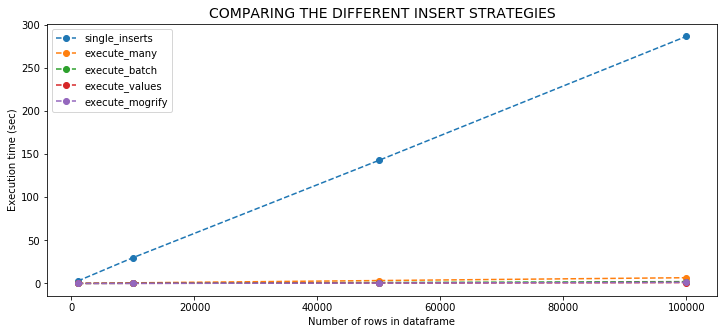

In [153]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,5))
for strategy in performances['strategy'].unique():
    subset = performances[performances['strategy'] == strategy]
    ax.plot(subset['nrows'], subset['time'], 'o--', label=strategy)

plt.xlabel('Number of rows in dataframe')
plt.ylabel('Execution time (sec)')
plt.title("COMPARING THE DIFFERENT INSERT STRATEGIES", fontsize=14)
plt.legend()
plt.show()

### CONCLUSION 1
If you care about speed, avoid doing single inserts at all costs.

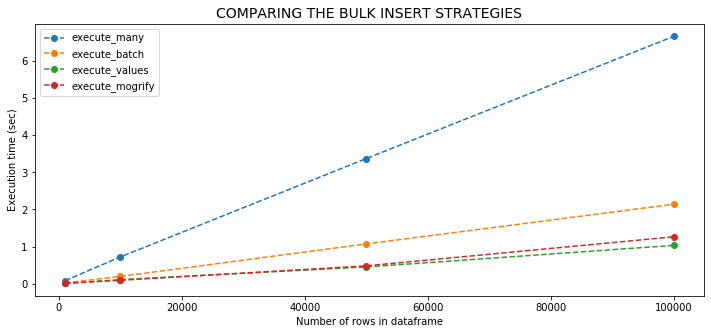

In [154]:
fig, ax = plt.subplots(figsize=(12,5))
for strategy in performances['strategy'].unique():
    if strategy != 'single_inserts':
        subset = performances[performances['strategy'] == strategy]
        ax.plot(subset['nrows'], subset['time'], 'o--', label=strategy)

plt.xlabel('Number of rows in dataframe')
plt.ylabel('Execution time (sec)')
plt.title("COMPARING THE BULK INSERT STRATEGIES", fontsize=14)
plt.legend()
plt.show()

### CONCLUSION 2
The true battle seems to happen between **execute_values()** and **execute_mogrify()**. Because the execute_values() is natively supportted by Psycopg2, this is the strategy that I will be using from now on.